# CTR Prediction on Avazu Dataset


Making predictions on the click through rate of ad impressions using Logistic Regression

Dataset can be found here: https://www.kaggle.com/c/avazu-ctr-prediction

## 1. Imports

In [166]:
import warnings
import numpy as np
import pandas as pd
import random
import matplotlib
import datetime

In [167]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from matplotlib import pyplot as plt
from datetime import date, datetime
from collections import Counter

In [168]:
#Ignore Warning Messages

warnings.filterwarnings('ignore')

## 2. Importing Data

### 2.1 Import the full dataset, about 4 million observations

In [169]:
df = pd.read_csv("data/train.csv")

### 2.2 Randomly sample data for testing, 1000 entries

In [170]:
line_count = 40428968

In [171]:
n = 1000
skip = sorted(random.sample(range(1,line_count + 1), line_count - n))

In [172]:
df = pd.read_csv("data/train.csv", skiprows=skip)

In [173]:
#Save the dataset for future use

df.to_csv('train_sample_1000.csv')

### 2.3 Feature Engineering

#### 2.3.1 Create weekday, hour, and area featues

In [174]:
# Weekday
df["weekday"] = df["hour"].apply(lambda x: datetime.strptime(str(x), '%y%m%d%H').weekday())

# Hour
df["hour"] = df["hour"].apply(lambda x: int(str(x)[-2:]))

# Area
df["area"] = df["C15"] * df["C16"]

#We know that C15 and C16 are hieght and width from https://www.kaggle.com/c/avazu-ctr-prediction/discussion/11099
#TODO: More feature engineering and interaction terms, keeping it simple for baseline

In [175]:
df.head()
# Confirm the dataset looks good

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,weekday,area
0,16764717219873609717,0,0,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,20596,320,50,2161,0,35,-1,157,1,16000
1,17155955771177698334,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,15708,320,50,1722,0,35,-1,79,1,16000
2,2532506500758047914,1,0,1010,1,85f751fd,c4e18dd6,50e219e0,f7dd00ec,7801e8d9,...,21665,320,50,2493,3,35,-1,117,1,16000
3,7545879159075585244,1,0,1005,1,5ee41ff2,17d996e6,f028772b,ecad2386,7801e8d9,...,16920,320,50,1899,0,431,100075,117,1,16000
4,14328363515097105218,0,1,1005,0,85f751fd,c4e18dd6,50e219e0,54c5d545,2347f47a,...,21611,320,50,2480,3,297,100111,61,1,16000


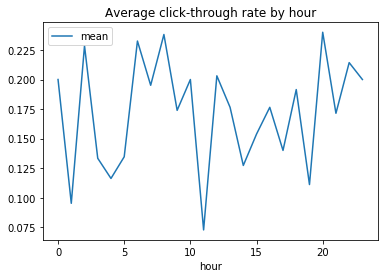

In [176]:
df.groupby(df.hour)['click'].agg(['mean']).plot()
plt.title('Average click-through rate by hour')
plt.show();



#### 2.3.2 Create user frequency feature: How often they appear and how many clicks on average.

In [64]:
#User
df['User'] = df['device_id'] + df['device_ip'] + df['device_model'] 

#Create values object from count to calculate user frequency, replace user with count
values = df['User'].value_counts() 

#User frequency
df['User_freq'] = df['User'].apply(lambda row: values[row])

#### 2.3.3 Create user clicks feature

In [65]:
# Should be consisten with the number of samples(1000)
i=0
for user in df['User']:
    df['User_clicks'] = df[df['User'] == user]['click'].mean()
    i=i+1
    if i%1e3==0:
        print(i)

1000


#### 2.3.4 Create input and target variables, including the new features

In [66]:
#Inputs
X = df[['C1', 'hour', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 
           'C19', 'C20','C21', 'area', 'weekday', 'User_freq']]
#Targets
y = df[['click']]


#### 2.3.5 Column C20 has listed null as -1, replace with mean

In [67]:
X['C20'] = X['C20'].replace(-1, np.nan)
X['C20'] = X['C20'].replace(np.nan, X['C20'].mean())

#### 2.3.6 One hot encoding with get_dummies

In [68]:
columns_to_encode = ['device_type', 'device_conn_type', 'site_category', 'app_category', 'banner_pos', 'C18']

In [69]:
df_full_columns = pd.read_csv("data/train_small.csv", usecols=columns_to_encode)

In [70]:
for col in columns_to_encode:
    X[col] = X[col].astype('category', categories = df_full_columns[col].unique().tolist())

In [71]:
X = pd.get_dummies(X, columns=columns_to_encode, prefix = columns_to_encode)

In [ ]:
#TODO hashing instead of one hot encode see:

#https://www.kdnuggets.com/2016/01/useful-data-science-feature-hashing.html

#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html

#https://stackoverflow.com/questions/8673035/what-is-feature-hashing-hashing-trick

### 2.4. Test train split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, shuffle=False)

## 3. Logistic Regression

In [139]:
#Hyperparameters
penalty = ['l1', 'l2']
C = [0.05, 0.1, 0.4, 0.5, 0.55, 0.6, 0.65]
#TODO-More hyperparameters https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


#Parameter Grib
param_grid = dict(penalty=penalty, 
                  C=C)
#Grid search
lr_gs = GridSearchCV(LogisticRegression(), param_grid, n_jobs=-1, scoring = 'roc_auc', verbose = 2)

#Fit model
grid_result_lr = lr_gs.fit(X_train,y_train)


Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    1.6s finished


In [141]:
#Find best score and hyperparameters associated with best score, then edit CV
print(lr_gs.best_params_)

{'C': 0.6, 'penalty': 'l2'}


In [142]:
lr = LogisticRegression(penalty='l2',
                        solver='liblinear',
                        C=0.6,
                        verbose=2)

In [143]:
lr.fit(X,y)

[LibLinear]

LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=2, warm_start=False)

In [144]:
lr_scores = cross_val_score(lr,
                            X_train, 
                            y_train, 
                            cv=5, 
                            scoring="roc_auc", 
                            n_jobs=-1, 
                            verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


## 4. Model Evaluation


### 4.1 Confusion Matrix

In [146]:
cm = confusion_matrix(y_train, y_test)


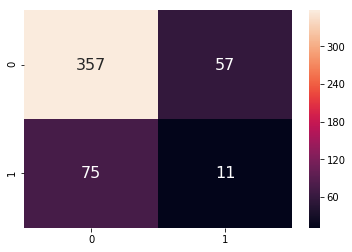

In [147]:

import seaborn as sn
sn.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')# font size

### 4.2 ROC AUC Score

In [148]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics


In [149]:
roc_auc_score(y_train, y_test)

0.4951129086619481

### 4.3 PRC Curve

In [150]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_test, pos_label=2)

In [151]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_train, y_test)


print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.17


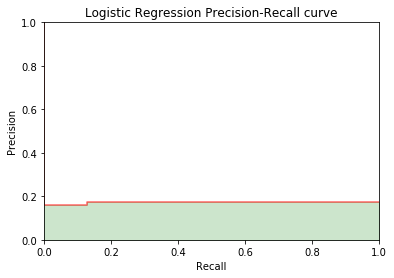

In [184]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_train, y_test)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='r', alpha=0.6,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='g', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Logistic Regression Precision-Recall curve')
plt.show();